#### ReadMe
This exercise is about Bitcoin. The data records all trades at Coinbase in March 2020. Unluckily, we only see market price and quantity traded. But the data gives the indicator of “BUY” or “SELL” on the taker side. This indicator is not available for most of equity trades dataset.

#### Questions: 

* Calculate Kyle’s lambda (market impact) for all the data in March
* Calculate Kyle’s lambda (market impact), volume, signed volume, volume-weighted price by day and hour
* Plot constructed variables in the previous bullet point 
* What patterns do you see? Make some comments
* Is there momentum in Bitcoin returns?
* Can you ﬁgure out good predictor variables for returns?
* Construct a trading strategy based on your analysis
* Plot the performance of the trading strategy 



In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 15.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [3]:
pip install datatable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 MB 4.0 MB/s eta 0:00:00


In [4]:
pip install regpyhdfe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Import the relevant modules

In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import yfinance as yf
import requests
from math import sqrt
import matplotlib.pyplot as plt
import datatable as dt
from datatable import dt, f, by, g, join, sort, update, ifelse
import os 
import math
from datetime import datetime
from regpyhdfe import Regpyhdfe


In [6]:
BTC=os.listdir ('BTC_coinbase_trades')
BTC_list = BTC[1:]
df_list=[]

In [7]:
# Read in all files in the folder (note that some files have difference sizes)
for i in range (20200301, 20200331):
    path = 'BTC_coinbase_trades' + "/" + str(i)
    df=pd.read_csv(path +"/"+'COINBASE_SPOT_BTC_USD.csv.gz', compression='gzip', header=0, sep=';')
    df_list.append (df)

In [45]:
df= pd.concat([df for df in df_list], ignore_index=True)
df

,time_exchange,time_coinapi,guid,price,base_amount,taker_side,id_coinapi,id_exch_guid,id_exch_int_inc,order_id_maker,order_id_taker
0,2020-03-01T00:00:00.0446140,2020-03-01T00:00:00.1414456,679ee89b-5519-43f1-923b-daded92057f3,8523.33,0.400000,BUY,NaN,NaN,NaN,NaN,NaN
1,2020-03-01T00:00:00.0446140,2020-03-01T00:00:00.1423443,d8e7d6bd-7393-4ec9-8e26-7908029c9d21,8523.33,0.060150,BUY,NaN,NaN,NaN,NaN,NaN
2,2020-03-01T00:00:00.3049610,2020-03-01T00:00:00.3886382,d0226b21-0475-44c2-9eaa-549c58af18b7,8523.33,0.001810,BUY,NaN,NaN,NaN,NaN,NaN
3,2020-03-01T00:00:00.6032220,2020-03-01T00:00:00.6882787,1ca08d8d-a93f-4f99-9797-68b2dc1f5c23,8523.32,0.017000,SELL,NaN,NaN,NaN,NaN,NaN
4,2020-03-01T00:00:00.6032220,2020-03-01T00:00:00.6889379,0e44b485-17e1-48d3-b0ae-2a46c3c43b38,8523.32,0.008014,SELL,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3459929,2020-03-30T23:59:59.0496940,2020-03-30T23:59:59.0882491,53927eab-8f60-49cd-801f-f5011fb8b603,6406.39,0.073297,SELL,NaN,NaN,NaN,NaN,NaN
3459930,2020-03-30T23:59:59.0617430,2020-03-30T23:59:59.1029168,c2cc4627-23c2-447e-87b4-b3ad15853317,6406.39,1.693517,SELL,NaN,NaN,NaN,NaN,NaN
3459931,2020-03-30T23:59:59.0860910,2020-03-30T23:59:59.1257373,023cf615-dde7-459d-9996-7d20100007b1,6406.39,0.233186,SELL,NaN,NaN,NaN,NaN,NaN
3459932,2020-03-30T23:59:59.2300870,2020-03-30T23:59:59.2710364,77e11a58-a6c2-4c4f-b37b-0d85122d78ab,6406.40,0.012000,BUY,NaN,NaN,NaN,NaN,NaN


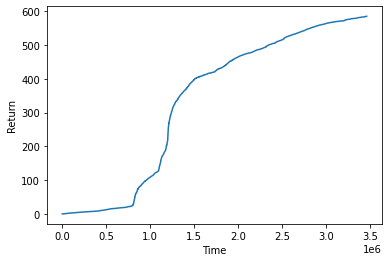

In [46]:
# Assign trading side
df['taker_side'] = df['taker_side'].replace({'BUY': 1, 'SELL': -1})

# Calculate trading signed trading volume (buy sell)
df['volume'] = df['base_amount'] * df['price']
df['signedvolume'] = df['base_amount'] * df['price'] * df['taker_side']

# Calculate return
df['pct_change'] = df['price'].pct_change()
df['return'] = np.where(df['taker_side'] == 1, df['pct_change'], 0)
df['return'] = np.where(df['taker_side'] == -1, -df['pct_change'], df['return'])
df['return'] = df['return'].dropna().cumsum()

# plot the return
df['return'].plot()
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()


#### Calculate price impact 
Note that price impact means price movement due to \$1 of trade of 1 share of trade
Question, why is it better to define price impact using $\Delta p$/\$ of trader than $\Delta p$/share of trade? 


Defining price impact using Δ𝑝/$ of trader is better than Δ𝑝/share of trade because it allows us to compare price impacts across different securities and different market conditions. The price of one share of a security can vary widely across different markets and even within the same market, making it difficult to compare the price impact of a trade across different securities or markets. On the other hand, by using the dollar value of the trade, we can compare the price impact of trades across different securities and markets, regardless of their underlying share price.

In [47]:
# Aggregate trades into chunks of 10,000 USD worth of trades
df['cum_base_amount'] = df['base_amount'].cumsum()
df['trade_chunk'] = (df['cum_base_amount'] / 10000).astype(int)

# Calculate price movement per chunk of trades
df['delta_price'] = df['price'].diff()
df['price_impact'] = df['delta_price'] / df['base_amount'].shift()

# Aggregate by trade chunk and calculate average price impact
price_impact_by_chunk = df.groupby('trade_chunk')['price_impact'].mean()
price_impact_by_chunk


trade_chunk
0     11506.633132
1     -8012.385658
2     13101.744753
3     -4387.298646
4     -2635.434331
          ...     
94    -5334.244416
95    12519.084246
96     1732.716618
97    -1373.383015
98   -52952.542539
Name: price_impact, Length: 99, dtype: float64

In [48]:
# Calculate price difference
df['deltap'] = df['price'].diff()

# Calculate price impact per $ of trader
df['price_impact'] = df['deltap'] / df['base_amount']
df

,time_exchange,time_coinapi,guid,price,base_amount,taker_side,id_coinapi,id_exch_guid,id_exch_int_inc,order_id_maker,order_id_taker,volume,signedvolume,pct_change,return,cum_base_amount,trade_chunk,delta_price,price_impact,deltap
0,2020-03-01T00:00:00.0446140,2020-03-01T00:00:00.1414456,679ee89b-5519-43f1-923b-daded92057f3,8523.33,0.400000,1,NaN,NaN,NaN,NaN,NaN,3409.332000,3409.332000,NaN,NaN,0.400000,0,NaN,NaN,NaN
1,2020-03-01T00:00:00.0446140,2020-03-01T00:00:00.1423443,d8e7d6bd-7393-4ec9-8e26-7908029c9d21,8523.33,0.060150,1,NaN,NaN,NaN,NaN,NaN,512.678044,512.678044,0.000000,0.000000,0.460150,0,0.00,0.000000,0.00
2,2020-03-01T00:00:00.3049610,2020-03-01T00:00:00.3886382,d0226b21-0475-44c2-9eaa-549c58af18b7,8523.33,0.001810,1,NaN,NaN,NaN,NaN,NaN,15.429699,15.429699,0.000000,0.000000,0.461960,0,0.00,0.000000,0.00
3,2020-03-01T00:00:00.6032220,2020-03-01T00:00:00.6882787,1ca08d8d-a93f-4f99-9797-68b2dc1f5c23,8523.32,0.017000,-1,NaN,NaN,NaN,NaN,NaN,144.896440,-144.896440,-0.000001,0.000001,0.478960,0,-0.01,-0.588235,-0.01
4,2020-03-01T00:00:00.6032220,2020-03-01T00:00:00.6889379,0e44b485-17e1-48d3-b0ae-2a46c3c43b38,8523.32,0.008014,-1,NaN,NaN,NaN,NaN,NaN,68.304097,-68.304097,0.000000,0.000001,0.486974,0,0.00,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459929,2020-03-30T23:59:59.0496940,2020-03-30T23:59:59.0882491,53927eab-8f60-49cd-801f-f5011fb8b603,6406.39,0.073297,-1,NaN,NaN,NaN,NaN,NaN,469.569232,-469.569232,-0.000002,585.597081,982766.427128,98,-0.01,-0.136431,-0.01
3459930,2020-03-30T23:59:59.0617430,2020-03-30T23:59:59.1029168,c2cc4627-23c2-447e-87b4-b3ad15853317,6406.39,1.693517,-1,NaN,NaN,NaN,NaN,NaN,10849.330758,-10849.330758,0.000000,585.597081,982768.120645,98,0.00,0.000000,0.00
3459931,2020-03-30T23:59:59.0860910,2020-03-30T23:59:59.1257373,023cf615-dde7-459d-9996-7d20100007b1,6406.39,0.233186,-1,NaN,NaN,NaN,NaN,NaN,1493.880010,-1493.880010,0.000000,585.597081,982768.353831,98,0.00,0.000000,0.00
3459932,2020-03-30T23:59:59.2300870,2020-03-30T23:59:59.2710364,77e11a58-a6c2-4c4f-b37b-0d85122d78ab,6406.40,0.012000,1,NaN,NaN,NaN,NaN,NaN,76.876800,76.876800,0.000002,585.597083,982768.365831,98,0.01,0.833333,0.01


In [49]:
df.columns

Index(['time_exchange', 'time_coinapi', 'guid', 'price', 'base_amount',
       'taker_side', 'id_coinapi', 'id_exch_guid', 'id_exch_int_inc',
       'order_id_maker', 'order_id_taker', 'volume', 'signedvolume',
       'pct_change', 'return', 'cum_base_amount', 'trade_chunk', 'delta_price',
       'price_impact', 'deltap'],
      dtype='object')

In [51]:
# Convert time_exchange to date only
df['date'] = df['time_exchange'].str.split('T', expand=True)[0]

# Calculate volume by day
df['volume'] = df['base_amount'] * df['price']
df_daily_vol = df.groupby('date')['volume'].sum().reset_index()
df_daily_vol = df_daily_vol.rename(columns={'volume': 'daily_volume'})

# Calculate signed volume by day
df['signed_volume'] = df['base_amount'] * df['price'] * df['taker_side']
df_daily_signed_vol = df.groupby('date')['signed_volume'].sum().reset_index()
df_daily_signed_vol = df_daily_signed_vol.rename(columns={'signed_volume': 'daily_signed_volume'})

# Calculate volume-weighted price by day
df_daily_vwap = df.groupby('date').apply(lambda x: (x['volume']*x['price']).sum() / x['volume'].sum()).reset_index()
df_daily_vwap.columns = ['date', 'daily_vwap']

# Merge daily volume, signed volume, and vwap to the main dataframe
df = df.merge(df_daily_vol, on='date')
df = df.merge(df_daily_signed_vol, on='date')
df = df.merge(df_daily_vwap, on='date')

In [54]:
df.columns

Index(['time_exchange', 'time_coinapi', 'guid', 'price', 'base_amount',
       'taker_side', 'id_coinapi', 'id_exch_guid', 'id_exch_int_inc',
       'order_id_maker', 'order_id_taker', 'volume', 'signedvolume',
       'pct_change', 'return', 'cum_base_amount', 'trade_chunk', 'delta_price',
       'price_impact', 'deltap', 'signed_volume', 'date', 'daily_volume',
       'daily_signed_volume', 'daily_vwap'],
      dtype='object')

In [55]:
df[['date','price','volume','deltap','signed_volume','daily_vwap','daily_signed_volume']]

,date,price,volume,deltap,signed_volume,daily_vwap,daily_signed_volume
0,2020-03-01,8523.33,3409.332000,NaN,3409.332000,8549.979402,5.779003e+06
1,2020-03-01,8523.33,512.678044,0.00,512.678044,8549.979402,5.779003e+06
2,2020-03-01,8523.33,15.429699,0.00,15.429699,8549.979402,5.779003e+06
3,2020-03-01,8523.32,144.896440,-0.01,-144.896440,8549.979402,5.779003e+06
4,2020-03-01,8523.32,68.304097,0.00,-68.304097,8549.979402,5.779003e+06
...,...,...,...,...,...,...,...
3459929,2020-03-30,6406.39,469.569232,-0.01,-469.569232,6317.653135,2.436595e+07
3459930,2020-03-30,6406.39,10849.330758,0.00,-10849.330758,6317.653135,2.436595e+07
3459931,2020-03-30,6406.39,1493.880010,0.00,-1493.880010,6317.653135,2.436595e+07
3459932,2020-03-30,6406.40,76.876800,0.01,76.876800,6317.653135,2.436595e+07


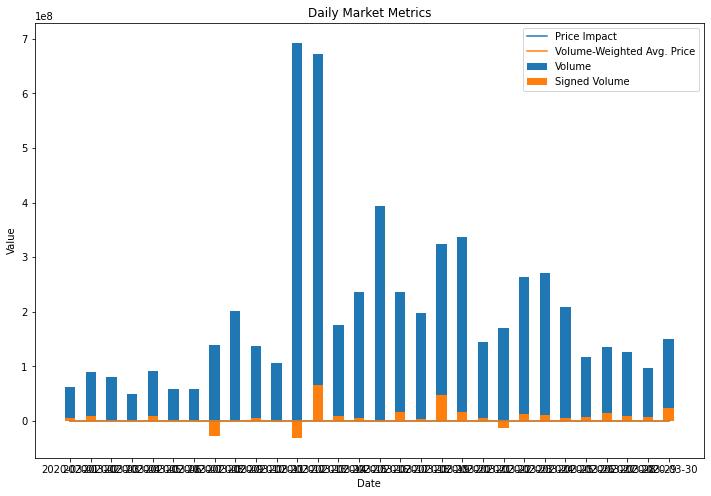

In [56]:
# Group the data by date
df_grouped = df.groupby('date')

# Calculate daily price impact, volume, signed volume, and volume-weighted price
daily_price_impact = df_grouped['price_impact'].mean()
daily_volume = df_grouped['volume'].sum()
daily_signed_volume = df_grouped['signedvolume'].sum()
daily_vwap = df_grouped['daily_vwap'].mean()

# Plot the data
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(daily_price_impact.index, daily_price_impact, label='Price Impact')
ax.plot(daily_vwap.index, daily_vwap, label='Volume-Weighted Avg. Price')
ax.bar(daily_volume.index, daily_volume, width=0.5, label='Volume')
ax.bar(daily_signed_volume.index, daily_signed_volume, width=0.5, label='Signed Volume')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Daily Market Metrics')
ax.legend()
plt.show()

##### Overall price impact

In [58]:
overall_price_impact = df['price_impact'].sum() / df['base_amount'].sum()
print("Overall price impact: {:.6f}".format(overall_price_impact))


Overall price impact: -1.501207


##### Price impact by hour
This requires to first aggregate data to data/hour level 

In [60]:
df['time_exchange'] = pd.to_datetime(df['time_exchange'])
df['time_coinapi'] = pd.to_datetime(df['time_coinapi'])


df_hourly = df.groupby([df['time_exchange'].dt.date, df['time_exchange'].dt.hour]).agg({
    'price_impact': 'mean',
    'signed_volume': 'sum'
})

<AxesSubplot:xlabel='time_exchange,time_exchange'>

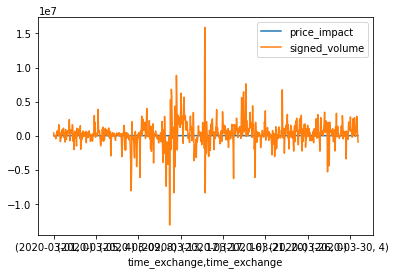

In [61]:
df_hourly.plot()

##### Forecasting Power of lambda
Try signed lambda 


<AxesSubplot:title={'center':'Signed Lambda Percentage Change'}, xlabel='date'>

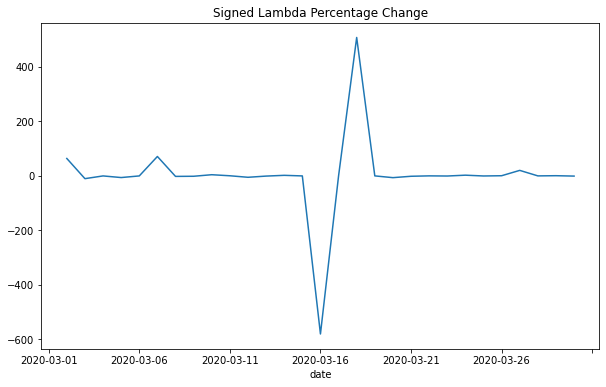

In [66]:
df_date = df.groupby('date').agg({'signed_volume': 'sum', 'price_impact': 'sum'})
#Calculate the signed lambda by dividing the sum of signed price impact by the sum of signed volume.
df_date['signed_lambda'] = df_date['price_impact'] / df_date['signed_volume']
df_date['signed_lambda_pct_change'] = df_date['signed_lambda'].pct_change()
df_date['signed_lambda_pct_change'].plot(figsize=(10, 6), title='Signed Lambda Percentage Change')


#### Trading Strategy based on Signed lambda

Signed lambda can be used as a signal for a trading strategy. If we have a positive signed lambda, it indicates that there is more buying pressure in the market, and we could consider taking a long position. On the other hand, if we have a negative signed lambda, it indicates more selling pressure, and we could consider taking a short position.

We could use a threshold for the signed lambda value to trigger a trade. For example, if the signed lambda is above a certain positive threshold, we could enter a long position, and if it is below a certain negative threshold, we could enter a short position.